# Road friction surface for Cambodia

```{important}
Please see [here](data_cam_friction) for more details
```

In [23]:
import pandas, geopandas
import contextily
import xarray, rioxarray
from rasterstats import zonal_stats

## Boundaries

```{important}
Please see [here](data_cam_s5) for more details
```

In [6]:
url = (
    "https://geonode.wfp.org/geoserver/wfs"\
    "?format_options=charset:UTF-8&"\
    "typename=geonode:khm_adm2_un&"\
    "outputFormat=SHAPE-ZIP&"\
    "version=1.0.0&"\
    "service=WFS&"\
    "request=GetFeature"
)
url

'https://geonode.wfp.org/geoserver/wfs?format_options=charset:UTF-8&typename=geonode:khm_adm2_un&outputFormat=SHAPE-ZIP&version=1.0.0&service=WFS&request=GetFeature'

In [7]:
cam = geopandas.read_file(url)

In [8]:
bb = cam.total_bounds

## Friction surfaces

### Motorised

In [20]:
out_fm = "cambodia_2020_motorized_friction_surface.tif"
! rm -f $out_fm
r = xarray.open_rasterio("2020_motorized_friction_surface.geotiff")
motor = r.rio.clip_box(*bb).squeeze()
motor.rio.to_raster(out_fm)
! du -h $out_fm

1.5M	cambodia_2020_motorized_friction_surface.tif


/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


### Walking

In [21]:
out_fw = "cambodia_2020_walking_friction_surface.tif"
! rm -f $out_fw
r = xarray.open_rasterio("2020_walking_only_friction_surface.geotiff")
walk = r.rio.clip_box(*bb).squeeze()
walk.rio.to_raster(out_fw)
! du -h $out_fw

1.5M	cambodia_2020_walking_friction_surface.tif


## Regional friction

- Motorised

In [39]:
agg_m = pandas.DataFrame(
    zonal_stats(
        cam,
        out_fm
    ),
    index = cam.index
)

- Walking

In [40]:
agg_w = pandas.DataFrame(
    zonal_stats(
        cam,
        out_fw
    ),
    index = cam.index
)

- Join together

In [46]:
db = cam[[
    "adm2_name", "adm2_altnm", "geometry"
]].join(
    agg_m[["mean"]].rename(columns={"mean": "motor_mean"})
).join(
    agg_w[["mean"]].rename(columns={"mean": "walk_mean"})
)
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   adm2_name   198 non-null    object  
 1   adm2_altnm  122 non-null    object  
 2   geometry    198 non-null    geometry
 3   motor_mean  198 non-null    float64 
 4   walk_mean   198 non-null    float64 
dtypes: float64(2), geometry(1), object(2)
memory usage: 7.9+ KB


## Visual overview

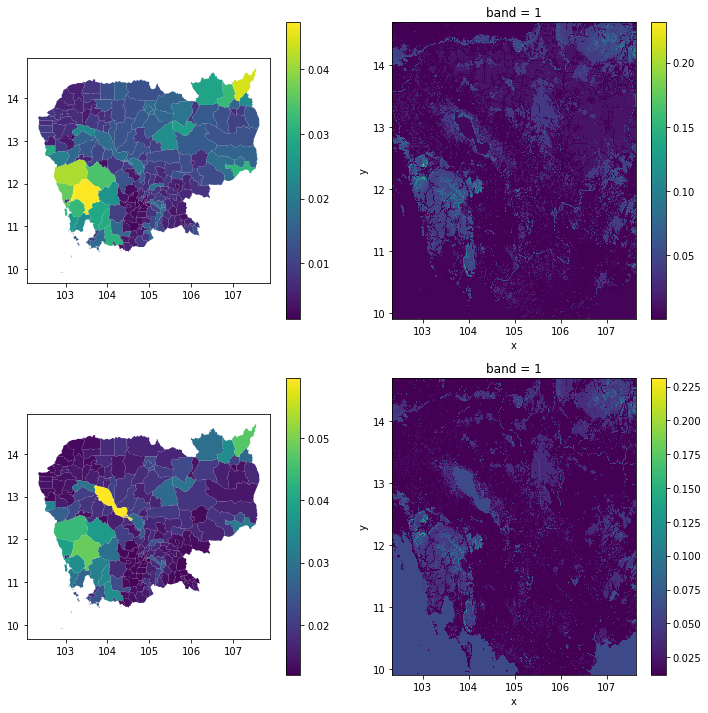

In [81]:
import matplotlib.pyplot as plt

f, axs = plt.subplots(2, 2, figsize=(12, 12))

db.plot("motor_mean", legend=True, ax=axs[0, 0])
r = xarray.open_rasterio(out_fm)
r.where(r>r.nodatavals).plot(ax=axs[0, 1])

db.plot("walk_mean", legend=True, ax=axs[1, 0])
r = xarray.open_rasterio(out_fw)
r.where(r>r.nodatavals).plot(ax=axs[1, 1])

plt.show()